In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
df = pd.read_csv("input.csv")
df.head()

,date,ticker,name,sector,industry,country,marketCap,price,change,volume
0,2022-03-22T00:00:00.0000000,TCN,Tricon Residential Inc.,Real Estate,Real Estate Services,Canada,0.0,17.01,0.0,0
1,2022-03-22T00:00:00.0000000,UNVR,Univar Solutions Inc.,Basic Materials,Chemicals,USA,0.0,33.78,0.0,0
2,2022-03-22T00:00:00.0000000,LNTH,"Lantheus Holdings, Inc.",Healthcare,Diagnostics & Research,USA,0.0,55.69,0.0,0
3,2022-03-22T00:00:00.0000000,TRTN,Triton International Limited,Industrials,Rental & Leasing Services,Bermuda,0.0,71.41,0.0,0
4,2022-03-22T00:00:00.0000000,IRTC,"iRhythm Technologies, Inc.",Healthcare,Medical Instruments & Supplies,USA,0.0,145.47,0.0,0


In [3]:
# clean up
# convert dates to datetime
# drop the data that does not have market cap values, very early data where I did not collect all the info

df['date'] = pd.to_datetime(df['date'])
df.drop(df[df["marketCap"] == 0].index, inplace=True)

In [4]:
df.head()

,date,ticker,name,sector,industry,country,marketCap,price,change,volume
98,2022-04-01,TECK,Teck Resources Limited,Basic Materials,Other Industrial Metals & Mining,Canada,2.176000e+10,42.15,4.35,4621608
99,2022-04-01,NEX,NexTier Oilfield Solutions Inc.,Energy,Oil & Gas Equipment & Services,USA,2.250000e+09,10.07,9.04,2926285
100,2022-04-01,SBS,Companhia de Saneamento Basico do Estado de Sa...,Utilities,Utilities - Regulated Water,Brazil,6.840000e+09,10.56,7.43,2849200
101,2022-04-01,ARLP,"Alliance Resource Partners, L.P.",Energy,Thermal Coal,USA,1.950000e+09,15.49,0.42,1493801
102,2022-04-01,GLNG,Golar LNG Limited,Energy,Oil & Gas Midstream,Bermuda,2.460000e+09,25.29,2.06,1306556


In [5]:
# some basic stats about the data for quick overview for sanity checks and general info

print("Number of rows: ", len(df))
print("Earliest record: ", df['date'].min())
print("Latest record: ", df['date'].max())
print("Number of days covered by data: ", df['date'].max() - df['date'].min())
print("Number of unique stocks: ", len(df['ticker'].unique()))

Number of rows:  307
Earliest record:  2022-04-01 00:00:00
Latest record:  2022-05-19 00:00:00
Number of days covered by data:  48 days 00:00:00
Number of unique stocks:  183


In [6]:
# calculate some of the values and put it into new dataframe for analysis

groupedByTicker = df.groupby("ticker")

df["number_of_appearances"] = groupedByTicker["date"].transform("count")
df["max_price"] = groupedByTicker["price"].transform("max")
df["min_price"] = groupedByTicker["price"].transform("min")
df["earliest_date"] = groupedByTicker["date"].transform("min")
df["latest_date"] = groupedByTicker["date"].transform("max")
df["price_change"] = (df["max_price"] - df["min_price"]) / df["min_price"]

new_highs_with_p_clean = df[df["price_change"] > 0].groupby("ticker").first().reset_index()

In [7]:
# quick overview
number_of_stocks_with_multiple_new_highs = len(new_highs_with_p_clean)
number_of_stocks_with_new_highs = len(df["ticker"].unique())

print("Number of stocks that had multiple appearances in new highs: ", number_of_stocks_with_multiple_new_highs)
print("Percentage out of total: ", round(number_of_stocks_with_multiple_new_highs / number_of_stocks_with_new_highs * 100, 2), "%")

print("Average gain: ", round(new_highs_with_p_clean["price_change"].mean() * 100, 2), "%")
print("Median gain: ", round(new_highs_with_p_clean["price_change"].median() * 100, 2), "%")

print("Average number of appearances: ", round(new_highs_with_p_clean["number_of_appearances"].mean(), 2))
print("Median number of appearances: ", round(new_highs_with_p_clean["number_of_appearances"].median(), 2))

Number of stocks that had multiple appearances in new highs:  72
Percentage out of total:  39.34 %
Average gain:  7.25 %
Median gain:  5.44 %
Average number of appearances:  2.72
Median number of appearances:  2.0


In [8]:
# some hypotheticals here. Assume that we enter every new high. Any stock that does not make a new all-time high
# is considered -5% loser. Otherwise we ride it to it's highest gain on the last all time high apparance

# this is not how we trade it, but I want a basic baseline/dumb trading strategy that I can compare to

win_rate = number_of_stocks_with_multiple_new_highs / number_of_stocks_with_new_highs
reward = new_highs_with_p_clean["price_change"].mean()
risk = 0.05
position_size = 3000
ev = position_size * reward * win_rate - position_size * risk * (1 - win_rate)

print("Win rate: ", round(win_rate * 100, 2), "%")
print("Reward: ", round(reward * 100, 2), "%")
print("Risk: ", risk)
print("R:R = ", round(reward / risk, 2))
print("Position Size: ", position_size)

# expected value
print("EV: ", round(ev, 2))

Win rate:  39.34 %
Reward:  7.25 %
Risk:  0.05
R:R =  1.45
Position Size:  3000
EV:  -5.47


As expected, we can't blindly just trade this. Also, it's debatable how this average reward will pan out -- it could be higher, or it could be lower. We will not nail the alltime high that's for sure, BUT with the profit targets split into three parts where we nail down parts of profit right away as well as moving stops up as the stock progresses - we could be doing better. For this we will need backtesting/simulation type code.

The idea is that we can enter a trade, sell a 3rd when it hits 7%, then 3rd when it hits 15%, then the remaining 3rd rides away. BUT, on each milestone, the stop loss is moved up. So achieving 5% gain means stop loss is moved to cost. Achieving 15% gain means stop loss moving to 7% gain.

And then I have stocks that made much higher highs but where not on the list because I use high volume filter. So basically need trading data for those tickers to get more accurate data.

<AxesSubplot:title={'center':'Median Price Change by Industry'}, xlabel='industry'>

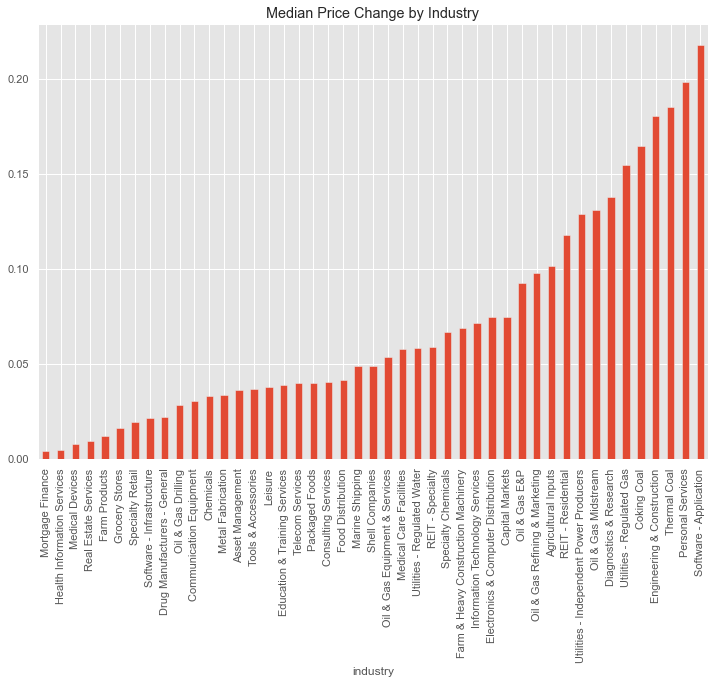

In [9]:
new_highs_with_p_clean.groupby("industry")["price_change"].median().sort_values().plot(kind="bar", title="Median Price Change by Industry")

<AxesSubplot:title={'center':'Number of appearances by industry'}, xlabel='industry'>

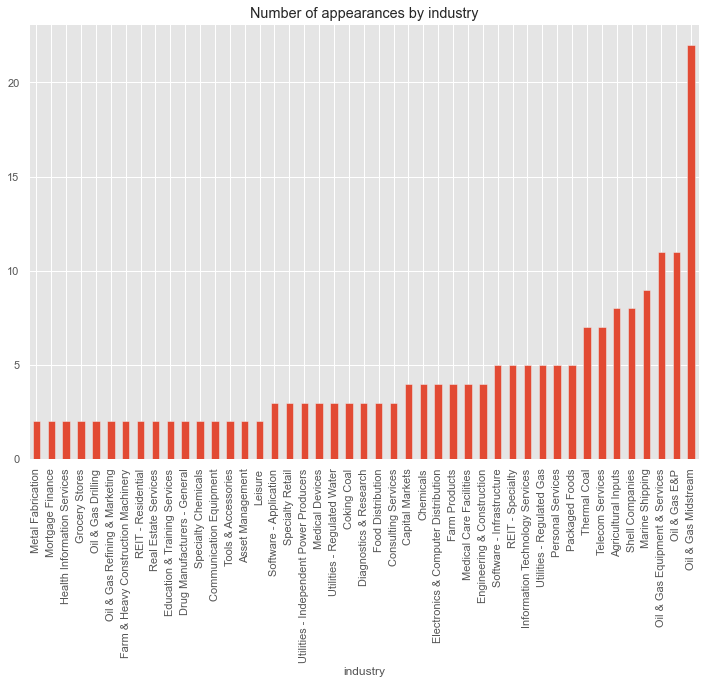

In [10]:
new_highs_with_p_clean.groupby("industry")["number_of_appearances"].sum().sort_values().plot(kind="bar", title="Number of appearances by industry")

<AxesSubplot:title={'center':'price_change'}, xlabel='sector'>

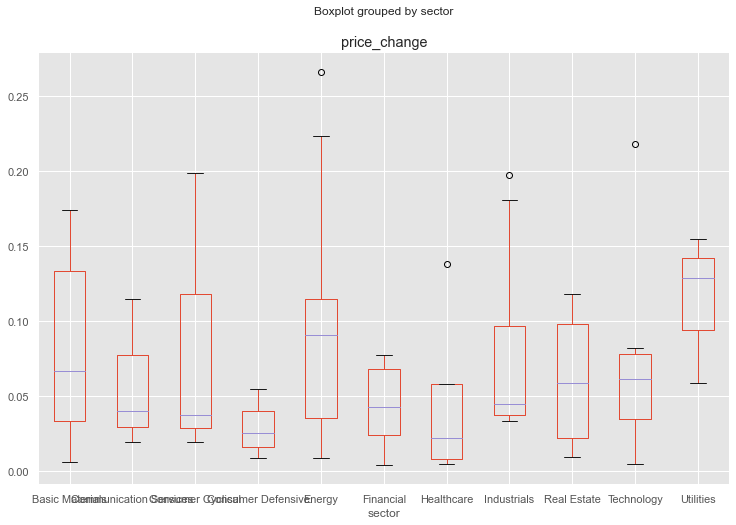

In [11]:
new_highs_with_p_clean.boxplot(column="price_change", by="sector")

<AxesSubplot:>

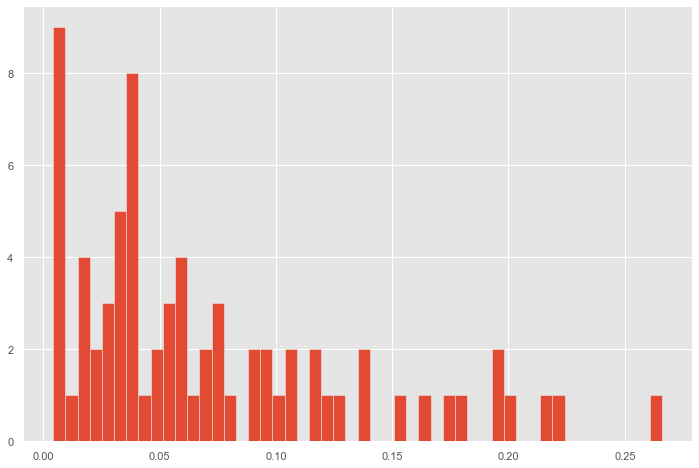

In [13]:
new_highs_with_p_clean["price_change"].hist(bins=50)

In [16]:
len(new_highs_with_p_clean[new_highs_with_p_clean["price_change"] <= 0.15])

62